## Recurrent Neural Networks

In [1]:
import os
os.environ["PYTHONHASHSEED"] = "0"

import random as rn
rn.seed(1254)

import numpy as np
np.random.seed(1515)

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import librosa, librosa.display, IPython.display as ipd
from tqdm import tqdm
import glob
import pandas as pd
import h5py
from sklearn import preprocessing
import pickle

In [2]:
plt.rcParams['figure.figsize'] = (14, 6)

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import tensorflow as tf
tf.set_random_seed(2)

config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1 
)

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(graph= tf.get_default_graph(), config=config) 
    
import keras 
from keras import backend as K
K.set_session(sess)  # set this TensorFlow session as the default session for Keras

from keras.layers import Input, Conv2D, MaxPooling2D, LSTM, GRU, Bidirectional
from keras.layers import Dense, Flatten
from keras.layers.core import Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [4]:
#SET PATHS
workspace = '/vol/vssp/AcousticEventsDetection/DLGdansk/UrbanSound/'

hdf5_path = os.path.join(workspace,'dataset.hdf5') 
modelfolder = os.path.join(workspace,'models')
scalerpath = os.path.join(workspace,'scaler.pkl')

In [5]:
# LOAD DATA
hf = h5py.File(hdf5_path, 'r')
X_train = np.array(hf.get('X_train') )
y_train = np.array(hf.get('y_train'))
X_val =  np.array(hf.get('X_val'))
y_val= np.array(hf.get('y_val'))
X_test = np.array(hf.get('X_test'))
y_test = np.array(hf.get('y_test'))

n_features= hf.get('n_features').value
n_frames=hf.get('max_length_samp').value
label_list= hf.get('label_list').value

In [6]:
# SCALE THE DATA
scaler=pickle.load(open(scalerpath, 'rb'))

X_train_scaled = [scaler.transform(x.T) for x in X_train]
X_val_scaled = [scaler.transform(x.T) for x in X_val]
X_test_scaled = [scaler.transform(x.T) for x in X_test]


In [7]:
def build_rnn(n_frames=n_frames, n_features=n_features,
                     n_classes=10):

    # INPUT
    x = Input(shape=(n_frames, n_features), dtype='float32')
  
    y= LSTM(120, return_sequences = True)(x)
    y= Dropout(0.2)(y)  
    
    y= LSTM(120)(y)
    y= Dropout(0.2)(y) 

    y = Dense(n_classes, activation='sigmoid')(y)

    m = Model(inputs=x, outputs=y)
    return m

In [8]:
m = build_rnn(n_features=40,)
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 173, 40)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 173, 120)          77280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 173, 120)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 120)               115680    
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1210      
Total params: 194,170
Trainable params: 194,170
Non-trainable params: 0
_________________________________________________________________


In [14]:
from keras.utils import plot_model
plot_model(m, to_file='figures/rnn_model_shape.png', show_shapes=True)

<img src='figures/rnn_model_shape.png'> 

In [9]:
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
model_checkpoint = ModelCheckpoint(
            os.path.join(modelfolder, 
                    'rnn_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.hdf5'),
            monitor='val_loss', 
            save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
callbacks = [early_stopping, model_checkpoint]

history = m.fit(x=np.array(X_train_scaled), y=y_train, batch_size=130,
                    epochs=200, verbose=True,
                    validation_data=(np.array(X_val_scaled), y_val), shuffle=True)

Train on 7079 samples, validate on 7079 samples
Epoch 1/200
7079/7079 [==============================] - 59s 8ms/step - loss: 1.8778 - acc: 0.3137 - val_loss: 1.6618 - val_acc: 0.4174
Epoch 2/200
7079/7079 [==============================] - 58s 8ms/step - loss: 1.5831 - acc: 0.4136 - val_loss: 1.5303 - val_acc: 0.4508
Epoch 3/200
7079/7079 [==============================] - 58s 8ms/step - loss: 1.5553 - acc: 0.4273 - val_loss: 1.4507 - val_acc: 0.4639
Epoch 4/200
7079/7079 [==============================] - 58s 8ms/step - loss: 1.4259 - acc: 0.4708 - val_loss: 1.3460 - val_acc: 0.4865
Epoch 5/200
7079/7079 [==============================] - 58s 8ms/step - loss: 1.3894 - acc: 0.4746 - val_loss: 1.4250 - val_acc: 0.4663
Epoch 6/200
7079/7079 [==============================] - 58s 8ms/step - loss: 1.4150 - acc: 0.4722 - val_loss: 1.2765 - val_acc: 0.5269
Epoch 7/200
7079/7079 [==============================] - 57s 8ms/step - loss: 1.3271 - acc: 0.5050 - val_loss: 1.3258 - val_acc: 0.5088


7079/7079 [==============================] - 57s 8ms/step - loss: 0.5060 - acc: 0.8360 - val_loss: 0.4010 - val_acc: 0.8741
Epoch 61/200
7079/7079 [==============================] - 56s 8ms/step - loss: 0.4517 - acc: 0.8566 - val_loss: 0.4053 - val_acc: 0.8730
Epoch 62/200
7079/7079 [==============================] - 57s 8ms/step - loss: 0.4266 - acc: 0.8626 - val_loss: 0.3433 - val_acc: 0.8911
Epoch 63/200
7079/7079 [==============================] - 56s 8ms/step - loss: 0.4175 - acc: 0.8644 - val_loss: 0.3460 - val_acc: 0.8892
Epoch 64/200
7079/7079 [==============================] - 57s 8ms/step - loss: 0.3901 - acc: 0.8740 - val_loss: 0.3684 - val_acc: 0.8791
Epoch 65/200
7079/7079 [==============================] - 57s 8ms/step - loss: 0.3997 - acc: 0.8746 - val_loss: 0.3214 - val_acc: 0.8938
Epoch 66/200
7079/7079 [==============================] - 56s 8ms/step - loss: 0.3623 - acc: 0.8854 - val_loss: 0.3076 - val_acc: 0.9010
Epoch 67/200
7079/7079 [==============================

Epoch 120/200
7079/7079 [==============================] - 57s 8ms/step - loss: 0.1042 - acc: 0.9692 - val_loss: 0.0746 - val_acc: 0.9781
Epoch 121/200
7079/7079 [==============================] - 57s 8ms/step - loss: 0.2039 - acc: 0.9429 - val_loss: 0.1720 - val_acc: 0.9463
Epoch 122/200
7079/7079 [==============================] - 58s 8ms/step - loss: 0.1785 - acc: 0.9418 - val_loss: 0.1438 - val_acc: 0.9554
Epoch 123/200
7079/7079 [==============================] - 57s 8ms/step - loss: 0.1461 - acc: 0.9561 - val_loss: 0.1034 - val_acc: 0.9665
Epoch 124/200
7079/7079 [==============================] - 56s 8ms/step - loss: 0.1052 - acc: 0.9668 - val_loss: 0.1483 - val_acc: 0.9554
Epoch 125/200
7079/7079 [==============================] - 57s 8ms/step - loss: 0.1468 - acc: 0.9549 - val_loss: 0.0922 - val_acc: 0.9706
Epoch 126/200
7079/7079 [==============================] - 57s 8ms/step - loss: 0.1104 - acc: 0.9652 - val_loss: 0.1520 - val_acc: 0.9542
Epoch 127/200
7079/7079 [=========

7079/7079 [==============================] - 55s 8ms/step - loss: 0.1073 - acc: 0.9664 - val_loss: 0.0798 - val_acc: 0.9743
Epoch 180/200
7079/7079 [==============================] - 55s 8ms/step - loss: 0.0777 - acc: 0.9761 - val_loss: 0.0441 - val_acc: 0.9877
Epoch 181/200
7079/7079 [==============================] - 54s 8ms/step - loss: 0.0623 - acc: 0.9801 - val_loss: 0.0358 - val_acc: 0.9894
Epoch 182/200
7079/7079 [==============================] - 55s 8ms/step - loss: 0.0554 - acc: 0.9832 - val_loss: 0.0306 - val_acc: 0.9917
Epoch 183/200
7079/7079 [==============================] - 55s 8ms/step - loss: 0.0383 - acc: 0.9897 - val_loss: 0.0311 - val_acc: 0.9921
Epoch 184/200
7079/7079 [==============================] - 55s 8ms/step - loss: 0.0422 - acc: 0.9873 - val_loss: 0.0287 - val_acc: 0.9932
Epoch 185/200
7079/7079 [==============================] - 54s 8ms/step - loss: 0.0580 - acc: 0.9838 - val_loss: 0.0285 - val_acc: 0.9918
Epoch 186/200
7079/7079 [=======================

Text(0,0.5,u'Loss')

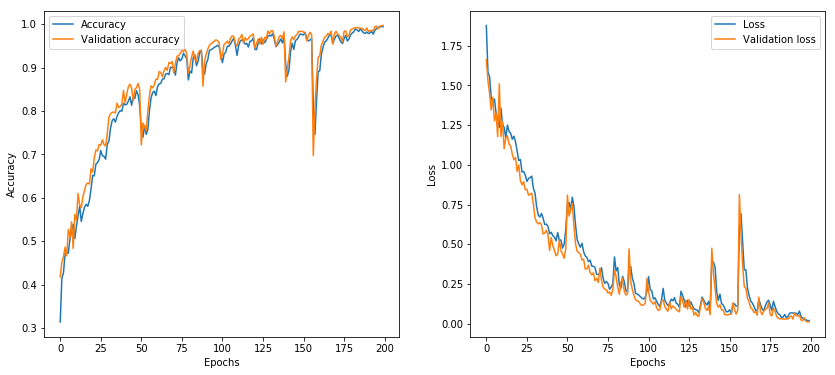

In [11]:
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='Accuracy')
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [12]:
prediction = m.predict(np.array(X_test_scaled), batch_size=130, verbose=1)
y_predict=np.array([ np.argmax(p) for p in prediction])
y_test_label = np.array([np.argmax(y) for y in y_test])

837/837 [==============================] - 1s 882us/step


Accuracy: 0.55


Text(0.5,32.0938,u'Predicted label')

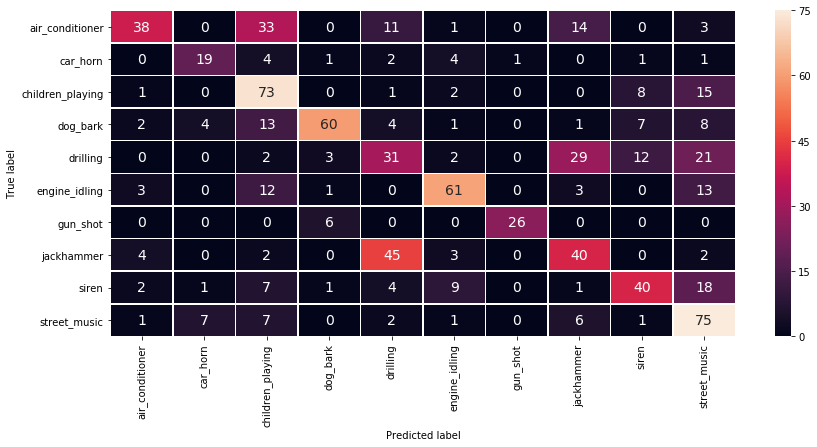

In [13]:
from sklearn.metrics import confusion_matrix

acc = np.sum(y_test_label==y_predict) / float(len(y_test_label))
print('Accuracy: {:.2f}'.format(acc))

cm = confusion_matrix(y_test_label, y_predict )
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5, 
            yticklabels=label_list,xticklabels=label_list)
plt.ylabel('True label')
plt.xlabel('Predicted label')